In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time

SEED = 420
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
!ls /kaggle/working

__notebook__.ipynb


## Lire les images

In [4]:
gpu = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpu)

#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#strategy = tf.distribute.experimental.TPUStrategy(tpu)

IMG_SHAPE = (16, 24, 3)

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [5]:
working_dir = '/kaggle/input/navires-2023-la-mano/'
data_dir = working_dir + 'ships16x24/ships_16x24_10cat/data'

In [6]:
classes = os.listdir(data_dir)
print(classes)
num_classes = len(classes)
print(num_classes)

['methanier_scaled', 'corvette_scaled', 'containership_scaled', 'cruiser_scaled', 'cv_scaled', 'coastguard_scaled', 'destroyer_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']
10


# Analyse and Preprocess Data

class    coastguard_scaled
size                1827.0
dtype: object
class    tug_scaled
size         5454.0
dtype: object


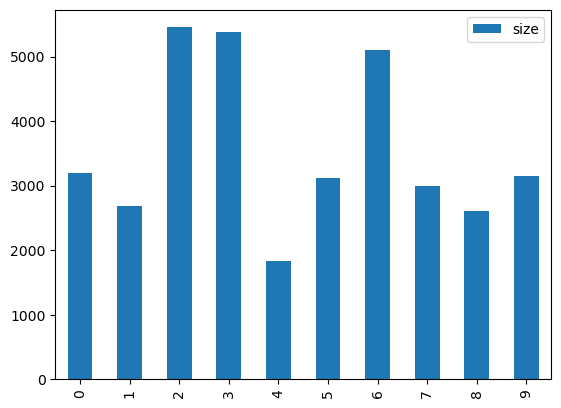

In [7]:
num_files = []
for classe in classes:
    num_files = np.append(num_files, len(os.listdir(os.path.join(data_dir, classe))))
    
df = pd.DataFrame()
df['class'] = classes
df['size'] = num_files
df.plot(kind='bar')

min_size = df.min()
print(min_size)
max_size = df.max()
print(max_size)

As we can see, the data is not homogenious, so we need to rebuilt it to have the same amount for each class, we do so because when we train with all the dataset, we have an overfitting.

## Class weights

In [8]:
total = df['size'].sum()
weights = (1 / df['size']) * (total / num_classes)
class_weight = weights.to_dict()

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.5,1.0),
        #shear_range=20.0,
        #channel_shift_range=20.0,
        validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="training",
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="validation",
        class_mode='categorical')

Found 31968 images belonging to 10 classes.
Found 3547 images belonging to 10 classes.


In [10]:
def plot_generator(generator):

    labels = generator.class_indices
    plt.figure(figsize=(14,10))
  
    # Get images and labels from the next batch
    img, lbls = generator.next()
    print(f'Batch size: {img.shape[0]}\nImage size: {img.shape[1]} x {img.shape[2]}\nCanals number: {img.shape[3]}')

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        num_class = np.where(lbls[i] == 1)[0][0]
        plt.title(list(labels.keys())[list(labels.values()).index(num_class)])
        plt.imshow(img[i])
    plt.show()

    generator.reset()

Batch size: 32
Image size: 16 x 24
Canals number: 3


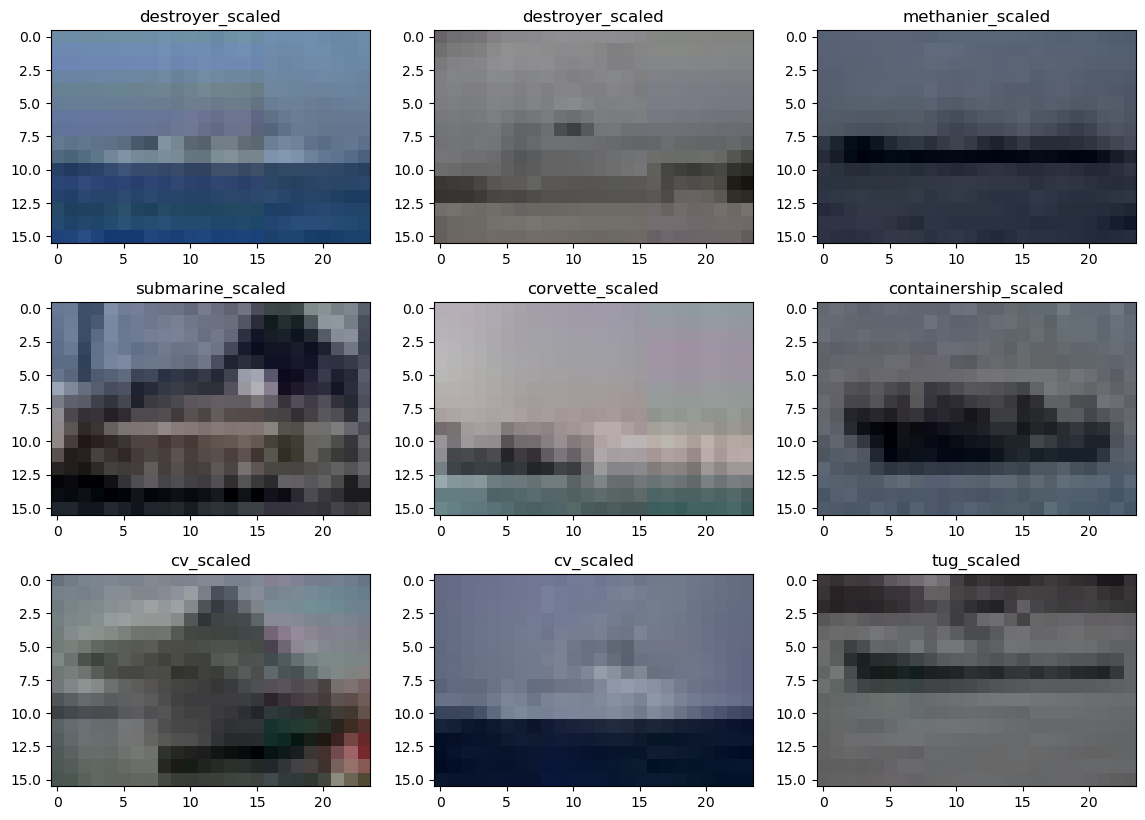

In [11]:
plot_generator(train_generator)

In [12]:
def plot_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
import math

class SGDRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, lr_decay, t_mult, epochs_per_restart, monitor='val_loss'):
        super(SGDRScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.lr_decay = lr_decay
        self.t_mult = t_mult
        self.epochs_per_restart = epochs_per_restart
        self.monitor = monitor
        self.best_score = float('inf')
        self.current_lr = initial_lr
        self.epochs_since_restart = 0
        self.total_epochs = 0
        self.history = {}
        
    def on_epoch_end(self, epoch, logs={}):
        self.total_epochs += 1
        self.epochs_since_restart += 1
        
        if self.monitor in logs:
            score = logs[self.monitor]
            if score < self.best_score:
                self.best_score = score
                
        if self.epochs_since_restart >= self.epochs_per_restart:
            self.current_lr = self.current_lr * self.lr_decay
            self.epochs_since_restart = 0
            
            self.model.optimizer.lr.assign(self.current_lr)
            
            print(f"\nLearning rate set to {self.current_lr}")
            
            self.history['lr'] = self.history.get('lr', []) + [self.current_lr]
            self.history['epochs'] = self.history.get('epochs', []) + [self.total_epochs]
            
    def on_train_end(self, logs=None):
        self.model.optimizer.lr.assign(self.initial_lr)
        print(f"\nFinal learning rate set to {self.initial_lr}")

In [14]:
import copy
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, init_lr, factor, patience):
        super(LearningRateScheduler, self).__init__()
        self.init_lr = init_lr
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_loss = float('inf')
        self.current_lr = init_lr
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        loss_val = logs.get('loss')
        if loss_val is None:
            return
        
        old_lr = copy.copy(self.current_lr)

        if loss_val < self.best_loss:
            self.best_loss = loss_val
            self.wait = 0 if self.wait <= 0 else self.wait - 1
            self.current_lr *= self.factor
            self.model.optimizer.lr.assign(self.current_lr)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                self.current_lr /= self.factor
                self.model.optimizer.lr.assign(self.current_lr)
                
        print(f"\nLearning rate:\nNew: {self.current_lr:.8f} Old: {old_lr:.8f}")

In [15]:
best_model_path = '/kaggle/working/model/best'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=2,
    min_lr=0.001)

initial_lr = 0.001
lr_decay = 0.1
t_mult = 2
epochs_per_restart = 10
factor = 1.1
patience = 2

sgdr = SGDRScheduler(initial_lr, lr_decay, t_mult, epochs_per_restart)
lr_scheduler = LearningRateScheduler(initial_lr, factor, patience)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='swish', input_shape=IMG_SHAPE),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='swish'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='swish'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Conv2D(512, 3, padding='same', activation='swish'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, 3, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.6),
        
        tf.keras.layers.GlobalMaxPooling2D(),

#         tf.keras.layers.Dense(2048, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
    return model

In [17]:
# buiding a model inside the strategy scope
with strategy.scope():
    model = build_model()

print("Nombre de couches : ", len(model.layers))
model.summary()

Nombre de couches :  29
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 24, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 16, 24, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 12, 64)        0         
 )                                                               
                                

In [18]:
EPOCHS = 200

In [19]:
start_time_multi = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[
        model_checkpoint,
        #lr_scheduler,
    ],
    max_queue_size=1000,
    use_multiprocessing=True,
    workers=10,
    class_weight=class_weight,
    epochs=EPOCHS
)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

Epoch 1/200


2023-05-24 17:33:48.178751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


999/999 [==============================] - 94s 51ms/step - loss: 2.0519 - accuracy: 0.3163 - val_loss: 1.8019 - val_accuracy: 0.3848
Epoch 2/200
999/999 [==============================] - 63s 62ms/step - loss: 1.6076 - accuracy: 0.4683 - val_loss: 1.3221 - val_accuracy: 0.5486
Epoch 3/200
999/999 [==============================] - 62s 62ms/step - loss: 1.4392 - accuracy: 0.5266 - val_loss: 1.2836 - val_accuracy: 0.5461
Epoch 4/200
999/999 [==============================] - 72s 71ms/step - loss: 1.3338 - accuracy: 0.5615 - val_loss: 1.1700 - val_accuracy: 0.5906
Epoch 5/200
999/999 [==============================] - 61s 59ms/step - loss: 1.2683 - accuracy: 0.5831 - val_loss: 1.2321 - val_accuracy: 0.5774
Epoch 6/200
999/999 [==============================] - 70s 68ms/step - loss: 1.2061 - accuracy: 0.6041 - val_loss: 1.0546 - val_accuracy: 0.6338
Epoch 7/200
999/999 [==============================] - 59s 58ms/step - loss: 1.1642 - accuracy: 0.6166 - val_loss: 1.0864 - val_accuracy: 0.63

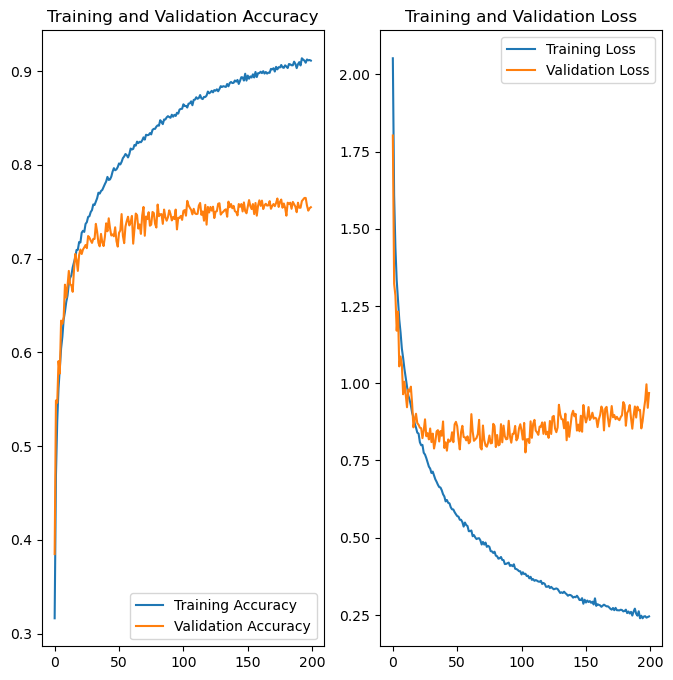

In [20]:
plot_result()

## Résultat à soumettre

In [21]:
model.load_weights(best_model_path)

In [22]:
X_test = np.load(working_dir + 'test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [23]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

116/116 [==============================] - 3s 11ms/step


In [24]:
!head submission.csv

Id,Category
0,3
1,4
2,5
3,1
4,3
5,0
6,3
7,3
8,5


In [25]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv